# Table of Contents

#### [Reference Papar and Analysis](#tag1)

#### [Ordinary Differential Equation](#tag2)

#### [How Many were Unreported?](#tag3)

#### More to come...

## Let's not forget these are people, not just numbers...

After reading this [paper](https://arxiv.org/pdf/2002.07572.pdf) by *Benjamin F. Maier*, I wanted to see if I can replicate the results and validate with real data. Furthermore, I want to see how many cases were unreported. Please note that there are multiple reasons to explain the unreported cases, including:

* Unable to identify/ diagnose the patients given the untypical symptoms;
* Unable to effectively sample the patients;
* PCR (polymerease chain reaction) results were false negative;
* Low test capacity, etc

This analysis is not intended to understand why there were unreported cases but rather to quantify how many cases were unidentified. I also cannot guarantee that I've understood the paper to 100%, so please let me know your thoughts!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# import networkx as nx
# import ndlib.models.epidemics as ep
import os
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.integrate import simps
from numpy import trapz
plt.style.use('ggplot')

<a id='tag1'></a>
## Reference Paper and Analysis

Here I copied the major equation from the original paper. Instead of SIR (susceptible, infectious, and recovered) model, the author used a **SIR-X** model, **X is the number of quarantined people**. To quantify the degree of public health measures to control the disease, there are several variables introduced:


* $\kappa_{0}$: containment rate, when it is zero, it corresponds to a scenario in which general population is unaffected by policies or does not commit behavior changes

* $\kappa$: isolation rate, which indicates the rate of infected being removed from the population, when it is zero, it corresponds to a scenario in which symptomatic infecteds are not isolated specifically.

* $\alpha$: infection rate

* $\beta$: recovery rate

The system of differential equations are as follows (see page 3 of the paper):

$$\partial_{t}S = -\alpha SI - \kappa_{0}S$$
$$\partial_{t}I = \alpha SI - \beta I -\kappa_{0}I - \kappa I$$
$$\partial_{t}X =(\kappa + \kappa_{0})I$$

Apart from that, the author used **free R_0 and effective R_0**, to differentiate the efficiency of transmission under different environments ($R_{0}$ can change depending on the environment)

<a id='tag2'></a>
## Ordinary Differential Equation

Before we tried to use ODE to solve the system, we need to determine a few parameters. We first chose to model based on paramters listed on *Table 1* of the paper.

In [2]:
## refer to table 1, Hubei
r_0_theory = 6.2
r_0_eff  = 3.28

## T_i is the time between infection and quanrantine
T_i_theory = 8
alpha = r_0_theory / T_i_theory

## 
beta = alpha/r_0_theory
print('alpha:', alpha, 'beta:', beta)


alpha: 0.775 beta: 0.125


Now we will use a system of equations to solve $\kappa$ and $\kappa_{0}$

In [3]:
# Q and P are from table 1
Q= 0.47
P = 0.66
def get_kapp(k):
    kappa_0 = k[0]
    kappa = k[1]
    
    F = np.empty((2))
    F[0] = (kappa_0+ kappa)/(beta+kappa_0 + kappa) - Q
    F[1] = kappa_0/(kappa+kappa_0) -P
    
    return F


kappaGuess = np.array([1,1])
(kappa_0, kappa) = fsolve(get_kapp,kappaGuess)
print('kappa_0: ',kappa_0, 'kappa: ',kappa)

kappa_0:  0.07316037735849022 kappa:  0.03768867924528316


Then here we use the equations above 

In [4]:
# solve the system dy/dt = f(y, t)
def f(y, t):
    S = y[0]
    I = y[1]
    X = y[2]
     # the model equations (see Munz et al. 2009)
    f0 = -alpha* S* I - kappa_0* S
    f1 = alpha* S* I - beta* I  - kappa_0* I - kappa*I 
    f2 = (kappa + kappa_0)* I 
    return [f0, f1, f2]

To initialize the equations, we followed the way of initialization in the paper. This includes finding the number of confirmed cases at the begining to use it to calculate $X(t_{0}), I(t_{0}) and S(t_{0})$

In [5]:
## import data
train = pd.read_csv('../input/covid19-global-forecasting-week-1/train.csv')
train['Date'] = pd.to_datetime(train.Date)

In [6]:
train[(train['Country/Region'] == 'China')&(train['Province/State']=='Hubei')].head(10)

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
3720,5581,Hubei,China,30.9756,112.2707,2020-01-22,444.0,17.0
3721,5582,Hubei,China,30.9756,112.2707,2020-01-23,444.0,17.0
3722,5583,Hubei,China,30.9756,112.2707,2020-01-24,549.0,24.0
3723,5584,Hubei,China,30.9756,112.2707,2020-01-25,761.0,40.0
3724,5585,Hubei,China,30.9756,112.2707,2020-01-26,1058.0,52.0
3725,5586,Hubei,China,30.9756,112.2707,2020-01-27,1423.0,76.0
3726,5587,Hubei,China,30.9756,112.2707,2020-01-28,3554.0,125.0
3727,5588,Hubei,China,30.9756,112.2707,2020-01-29,3554.0,125.0
3728,5589,Hubei,China,30.9756,112.2707,2020-01-30,4903.0,162.0
3729,5590,Hubei,China,30.9756,112.2707,2020-01-31,5806.0,204.0


In [7]:
hubei_df = train[(train['Country/Region'] == 'China')&(train['Province/State']=='Hubei')]

In [8]:
dti = pd.date_range('2020-01-21', '2020-03-10', freq='D')
len(dti)

50

In [9]:
## according to the paper page 6
# initial conditions
# use the number of cases 444
X0 = 444/(57.1*10**6)
I0 = 2.55*X0
S0 = 1-I0-X0
# initial death population
y0 = [S0, I0, X0]     # initial condition vector
t  = np.linspace(0, 50., 50)  # time grid
#print(y0)
# solve the DEs
soln = odeint(f, y0, t)
S = soln[:, 0]
I = soln[:, 1]
X = soln[:, 2]

Now we can plot the result as below along with the overlaying of **confirmed cases from the dataset**. We also multiply the number of cases to the factor of population to match the real world data. 

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


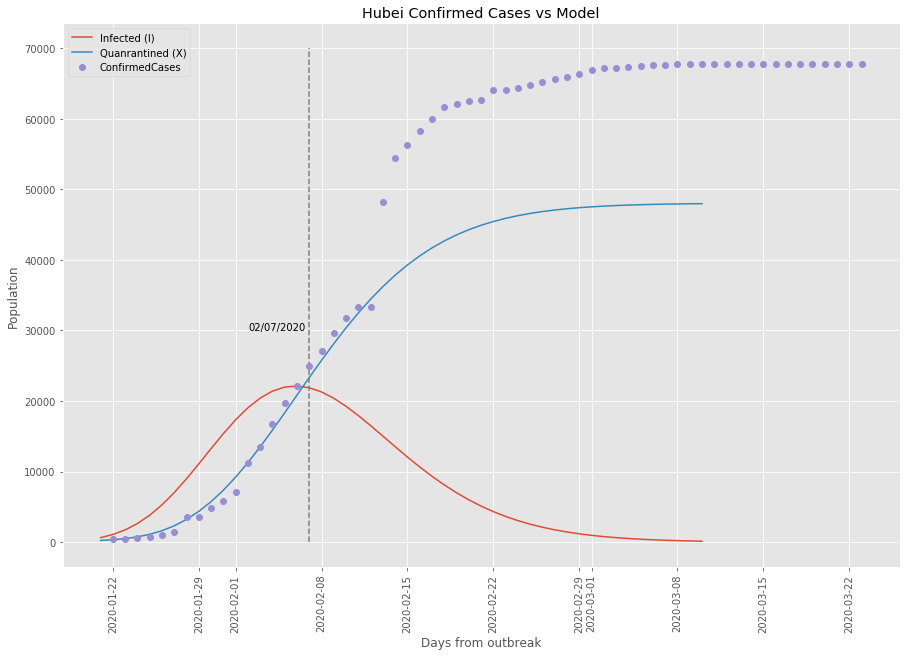

In [10]:
# plot results
plt.figure(figsize=(15, 10))
plt.title('Hubei Confirmed Cases vs Model')
#plt.plot(t, S, label='Living')
plt.plot(dti, I*57.1*10**6/(4.44/2.55), label='Infected (I)')
plt.plot(dti, X*57.1*10**6/(4.44/2.55), label='Quanrantined (X)')
plt.plot(hubei_df.Date, hubei_df.ConfirmedCases, 'o')
plt.vlines(x=pd.datetime(2020,2,7), ymin=0, ymax=70000, linestyles='dashed', color='grey')
plt.text(x=pd.datetime(2020,2,2), text='02/07/2020', y=30000,s=10)
plt.xlabel('Days from outbreak')
plt.ylabel('Population')
plt.legend(loc=0)
plt.xticks(rotation=90)
plt.show()

As demonstrated in the paper: *The model predicts the expected initial growth
of case numbers in Hubei Province followed by an algebraic
growth episode for ≈ 11 days until the saturation sets in, a consequence of the decay of unidentified infected individuals after a peak time around Feb. 7th (see Fig. 2A).*

<a id='tag3'></a>
## How many cases were unreported?

Befor quanratine measures became effective, the early infected cases were unreported. We can calculate the difference between the infection curve and confirmed cases in the same time window.

In [11]:
len(pd.date_range('2020-01-21', '2020-02-07'))

18

In [12]:
total_number_infection = (I*57.1*10**6/(4.44/2.55))[:18]

In [13]:
total_number_confirm = hubei_df.ConfirmedCases[:18]

In [14]:
under_report = total_number_infection - total_number_confirm

In [15]:
under_report_pcnt = under_report/total_number_infection*100

In [16]:
under_report.sum()/total_number_infection.sum()

0.23376732368128503

Accoding to this calculation, from Jan 21 to Feb 7, there are about 23% cases were unreported.

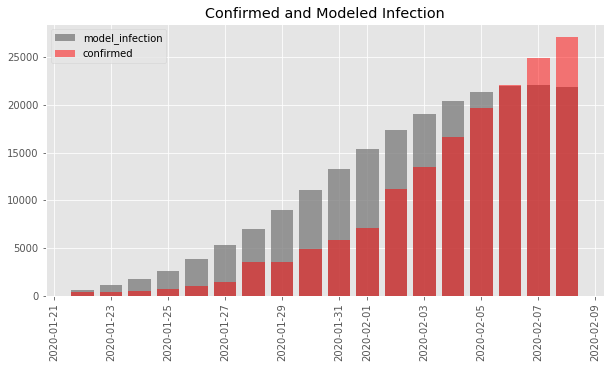

In [17]:
plt.figure(figsize=(10,5))
plt.title('Confirmed and Modeled Infection')
plt.bar(hubei_df.Date[:18], total_number_infection, alpha=.8, color='grey', label='model_infection')
plt.bar(hubei_df.Date[:18], total_number_confirm, alpha=.5, color='red', label='confirmed')
plt.xticks(rotation=90)
plt.legend()
plt.show()

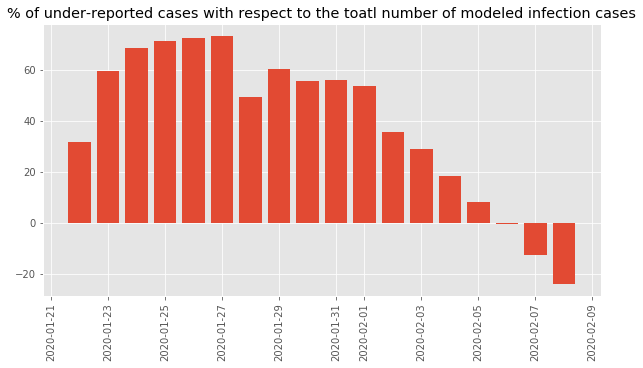

In [18]:
plt.figure(figsize=(10,5))
plt.title('% of under-reported cases with respect to the toatl number of modeled infection cases')
plt.bar(hubei_df.Date[:18], under_report_pcnt)
plt.xticks(rotation=90)
plt.show()